# Layoff Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Inpute packages

!pip install pmdarima
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.3 MB/s eta 0:00:00


In [2]:
# Input data files are available in the read-only "../input/" directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/layoffs-2022/layoffs.csv


In [3]:
df = pd.read_csv('/kaggle/input/layoffs-2022/layoffs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2545 entries, 0 to 2544
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2545 non-null   object 
 1   location             2545 non-null   object 
 2   industry             2543 non-null   object 
 3   total_laid_off       1746 non-null   float64
 4   percentage_laid_off  1694 non-null   float64
 5   date                 2543 non-null   object 
 6   stage                2539 non-null   object 
 7   country              2545 non-null   object 
 8   funds_raised         2297 non-null   float64
dtypes: float64(3), object(6)
memory usage: 179.1+ KB


In [4]:
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,N26,Berlin,Finance,71.0,0.04,2023-04-28,Series E,United States,1700.0
1,Providoor,Melbourne,Food,NaN,1.00,2023-04-28,Unknown,Australia,NaN
2,Dropbox,SF Bay Area,Other,500.0,0.16,2023-04-27,Post-IPO,United States,1700.0
3,Vroom,New York City,Transportation,120.0,0.11,2023-04-27,Post-IPO,United States,1300.0
4,Greenhouse,New York City,Recruiting,100.0,0.12,2023-04-27,Private Equity,United States,110.0


In [5]:
df.describe() # numeric values in reasonable range

,total_laid_off,percentage_laid_off,funds_raised
count,1746.000000,1694.000000,2297.000000
mean,256.022337,0.260577,814.143794
std,841.557354,0.258415,5448.104463
min,3.000000,0.000000,0.000000
25%,38.000000,0.100000,50.000000
50%,80.000000,0.170000,156.000000
75%,180.000000,0.300000,442.000000
max,12000.000000,1.000000,121900.000000


In [6]:
df.country.value_counts()[:10] # check top 10 countries which the layoffs companies in

United States     1649
India              169
Canada             108
United Kingdom      80
Brazil              76
Germany             72
Australia           63
Israel              56
Singapore           35
Indonesia           26
Name: country, dtype: int64

In [7]:
# keep only companies in US
df = df[df.country == 'United States']
df.shape

(1649, 9)

In [8]:
# check NaN values
df.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         551
percentage_laid_off    552
date                     1
stage                    4
country                  0
funds_raised           136
dtype: int64

In [9]:
# drop rows missing industry and stage data
df = df[df.industry.notna() & df.stage.notna()]
df.shape

(1644, 9)

## 1. Which industries within the tech sector are experiencing the most significant impact from layoffs?

In [10]:
df.industry.nunique() # total number of industries

29

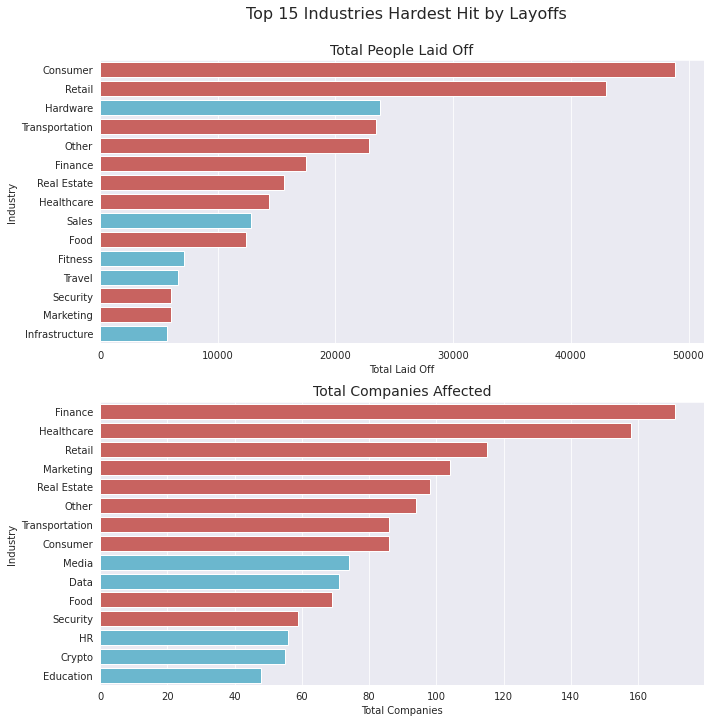

In [11]:
# Visualize top industries

# Top 15 indusries by total layoffs
indsSum = df[['industry', 'total_laid_off']] \
            .groupby('industry', as_index=False).sum() \
            .sort_values(by='total_laid_off', ascending=False)

# Top 15 indusries by total layoff companies
indsCount = df[['industry', 'company']] \
            .groupby('industry', as_index=False).count() \
            .sort_values(by='company', ascending=False)

# Industries in both top ranks
inds = [i for i in indsSum.industry[:15] if i in indsCount.industry[:15].tolist()]

# Create a custom palette to highlight the overlapping industries
palette = ['#d9534f' if industry in inds else '#5bc0de' for industry in indsSum.industry[:15]]

# Create a figure and set the size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.suptitle('Top 15 Industries Hardest Hit by Layoffs', fontsize=16, x=0.57, y=1)

# First subplot (top)
sns.barplot(ax=axes[0], data=indsSum.iloc[:15], x='total_laid_off', y='industry', palette=palette)
axes[0].set_title('Total People Laid Off', fontsize=14)
axes[0].set_xlabel('Total Laid Off')
axes[0].set_ylabel('Industry')

# Update the palette for the second plot
palette = ['#d9534f' if industry in inds else '#5bc0de' for industry in indsCount.industry[:15]]

# Second subplot (bottom)
sns.barplot(ax=axes[1], data=indsCount.iloc[:15], x='company', y='industry', palette=palette)
axes[1].set_title('Total Companies Affected', fontsize=14)
axes[1].set_xlabel('Total Companies')
axes[1].set_ylabel('Industry')

# Adjust the layout and display the combined plots
plt.tight_layout()
plt.show()

In [12]:
inds

['Consumer',
 'Retail',
 'Transportation',
 'Other',
 'Finance',
 'Real Estate',
 'Healthcare',
 'Food',
 'Security',
 'Marketing']

In [13]:
df["percentage_laid_off"].describe()

count    1093.000000
mean        0.250194
std         0.251592
min         0.000000
25%         0.100000
50%         0.160000
75%         0.290000
max         1.000000
Name: percentage_laid_off, dtype: float64

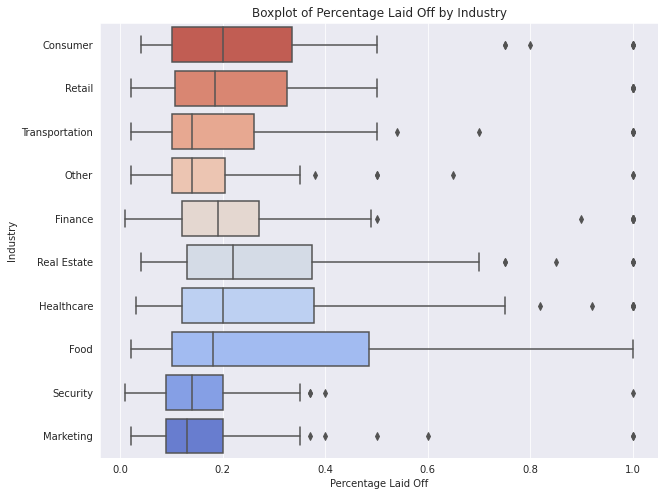

In [14]:
# boxplot of pct layoff
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="percentage_laid_off", y="industry", data=df, order=inds, palette='coolwarm_r')
plt.title('Boxplot of Percentage Laid Off by Industry')
plt.xlabel('Percentage Laid Off')
plt.ylabel('Industry')
plt.show()

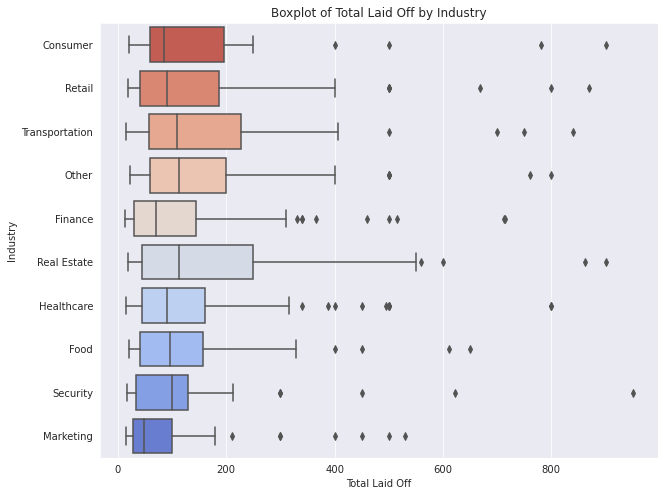

In [15]:
# boxplot of total layoff

# remove outliers (initial's range heavily shrinked with large outliers)
q_low = df["total_laid_off"].quantile(0.05)
q_hi  = df["total_laid_off"].quantile(0.95)
df_filtered = df[(df["total_laid_off"] < q_hi) & (df["total_laid_off"] > q_low)]

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="total_laid_off", y="industry", data=df_filtered, order=inds, palette='coolwarm_r')
plt.title('Boxplot of Total Laid Off by Industry')
plt.xlabel('Total Laid Off')
plt.ylabel('Industry')
plt.show()

## 2. What is the relationship between the financing status (stage of funding, funds raised) of companies and the percentage of layoffs they have experienced? 

### 2.1 Financing status of companies with high layoff rates

In [16]:
df["percentage_laid_off"].describe() # check layoff rate that higher than 75% companies

count    1093.000000
mean        0.250194
std         0.251592
min         0.000000
25%         0.100000
50%         0.160000
75%         0.290000
max         1.000000
Name: percentage_laid_off, dtype: float64

In [17]:
# Filter companies with a layoff rate higher than 0.29
top_layoff_companies = df[df.percentage_laid_off > 0.29]

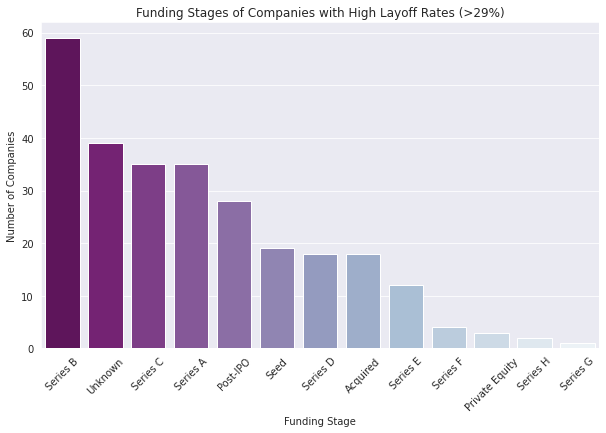

In [18]:
# Count the funding stages for these companies
stage_counts = top_layoff_companies.stage.value_counts()

# Create a bar plot for the funding stages of high layoff rate companies
plt.figure(figsize=(10, 6))
sns.barplot(x=stage_counts.index, y=stage_counts.values, palette='BuPu_r')
plt.title('Funding Stages of Companies with High Layoff Rates (>29%)')
plt.xlabel('Funding Stage')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

Here's the table covers the stages mentioned in the visualization:

| Stage | Description |
| ----- | ----------- |
| Seed | Early-stage funding from investors to help launch the startup. |
| Series A | Funding round to help the company grow and refine its product/market fit. |
| Series B | Funding round to help the company scale and expand to new markets. |
| Series C | Funding round to help the company continue its growth and prepare for an exit (IPO or acquisition). |
| Series D, E, F, G, H | Subsequent funding rounds for further growth, expansion, and potential acquisitions. These rounds usually involve larger investments than earlier rounds. |
| Private Equity | A type of financing that involves investing in privately-held companies, often for growth or acquisitions. This funding may be used for buyouts, recapitalizations, or other purposes. |
| Post-IPO | The stage after the company goes public through an initial public offering (IPO). At this stage, the company is publicly traded and has access to additional capital through the public markets. |
| Acquired | The company has been bought by another company, either for its technology, talent, or market share. This is an exit strategy for the investors and founders. |
| Unknown | The funding stage is not known or hasn't been disclosed. |

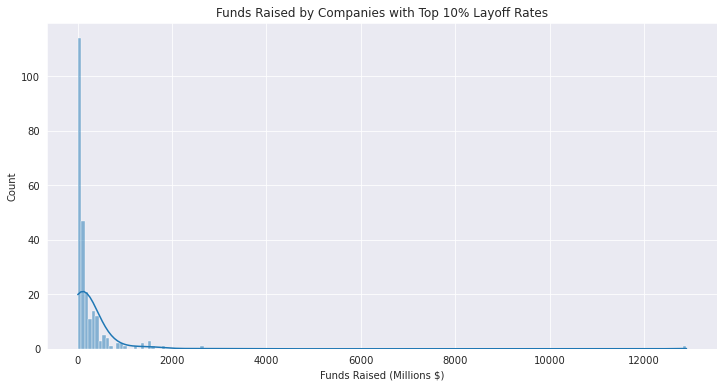

In [19]:
# Create fund raised distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=top_layoff_companies, x='funds_raised', kde=True)
plt.title('Funds Raised by Companies with Top 10% Layoff Rates')
plt.xlabel('Funds Raised (Millions $)')
plt.ylabel('Count')
plt.show()

**The Interquartile Range (IQR)** method is a popular technique for detecting and filtering outliers in a dataset because it is resistant to the influence of extreme values. It is based on the spread of the middle 50% of the data, which is less sensitive to extreme values than other methods, such as using the mean and standard deviation.

The IQR is defined as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data. It represents the range where the central 50% of the data points are located. The IQR method is particularly useful for datasets that have skewed distributions or heavy-tailed distributions because it only considers the middle portion of the data, making it less affected by extreme values.

When using the IQR method to filter outliers, a common approach is to define lower and upper bounds as follows:

- Lower bound = Q1 - 1.5 * IQR
- Upper bound = Q3 + 1.5 * IQR

Any data point that falls below the lower bound or above the upper bound is considered an outlier. This approach is based on the assumption that the central 50% of the data is a good representation of the overall dataset, and values that deviate significantly from this central region are likely to be anomalies or outliers.

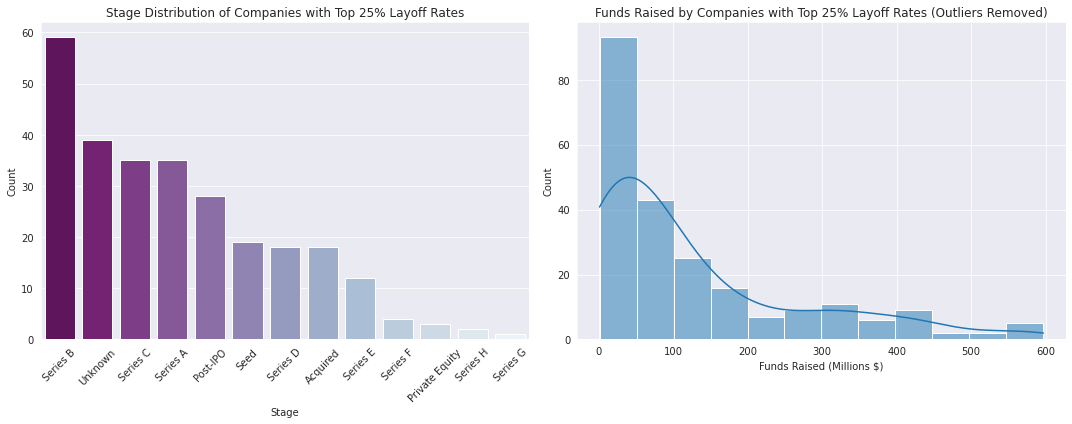

In [20]:
# Combine and improve figures
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stage bar chart
stage_counts = top_layoff_companies['stage'].value_counts()
sns.barplot(x=stage_counts.index, y=stage_counts.values, palette='BuPu_r', ax=axes[0])
axes[0].set_title('Stage Distribution of Companies with Top 25% Layoff Rates')
axes[0].set_xlabel('Stage')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Remove large outliers using IQR method
Q1 = top_layoff_companies['funds_raised'].quantile(0.25)
Q3 = top_layoff_companies['funds_raised'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_top_layoff_companies = top_layoff_companies[(top_layoff_companies['funds_raised'] >= lower_bound) &
                                                      (top_layoff_companies['funds_raised'] <= upper_bound)]

# Funds Raised histogram
sns.histplot(data=filtered_top_layoff_companies, x='funds_raised', kde=True, ax=axes[1])
axes[1].set_title('Funds Raised by Companies with Top 25% Layoff Rates (Outliers Removed)')
axes[1].set_xlabel('Funds Raised (Millions $)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 2.2 Relationship


The stage categories provide a way to classify companies based on their funding progress, which can help us understand their financial stability and potential for growth. These categories are often used by investors, analysts, and other stakeholders to assess a company's maturity and potential risk. In this analysis, we consider five stage categories, each representing a different phase of a company's development:

**Seed:** At the seed stage, companies are typically in their earliest stage of development. They may have limited resources and are often focused on validating their business idea, building a minimum viable product (MVP), and acquiring initial customers. Funding at this stage is often used to cover initial expenses and operational costs.

**Early:** Early-stage companies include those that have progressed beyond the seed stage and have secured Series A or Series B funding. These companies have typically demonstrated product-market fit and may be experiencing rapid growth. Funding at this stage is often used to support scaling efforts, such as expanding the team, increasing marketing efforts, and developing new product features.

**Late:** Late-stage companies have usually secured Series C funding or beyond, including Series D, E, F, G, H, I, and Private Equity investments. These companies are often well-established with a strong customer base, robust revenue streams, and a more mature business model. Funding at this stage is often used to accelerate growth, explore new markets, or pursue strategic acquisitions.

**Post-IPO:** Companies that have gone public through an initial public offering (IPO) or have been acquired fall into this category. These organizations are typically more mature and have access to additional financial resources, either through public markets or the backing of larger parent companies. They may continue to grow and innovate, but their focus often shifts to maintaining market share, increasing profitability, and meeting the expectations of shareholders or parent companies.

**Unknown or Subsidiary:** This category includes companies with unknown or unclear funding status, as well as those that are subsidiaries of larger organizations. Their stage of development can vary significantly, and their financial stability may be more dependent on the success of their parent company or other external factors. It is important to consider these companies on a case-by-case basis, as their circumstances can vary widely.

By categorizing companies according to these stages, we can better understand the relationship between funding progress and various company performance metrics, such as layoffs and financial stability.

In [21]:
stage_categories = ['Seed', 'Early', 'Late', 'Post-IPO', 'Unknown']
stages = [['Seed'], ['Series A', 'Series B'], ['Series C', 'Series D', 'Series E', 'Series F', 'Series G', 'Series H', 'Series I', 'Private Equity'],
          ['Post-IPO', 'Acquired'], ['Unknown', 'Subsidiary']]

# Creating a dictionary to map the stages to their respective categories
mapping = {stage: category for category, stage_list in zip(stage_categories, stages) for stage in stage_list}

# Creating the 'stage_category' column in the dataframe
df['stage_category'] = df['stage'].replace(mapping)

`pearsonr` and `spearmanr` are two different correlation coefficients that measure the strength and direction of association between two variables. They come from the `scipy.stats` module, which provides statistical functions in the **SciPy library**.

**Pearson's correlation coefficient (pearsonr):** It measures the linear relationship between two continuous variables. Pearson's correlation assumes that both variables are normally distributed and have a linear relationship. The coefficient ranges from -1 to 1, where -1 indicates a strong negative linear relationship, 1 indicates a strong positive linear relationship, and 0 indicates no linear relationship. Pearson's correlation is sensitive to outliers, meaning that extreme values in the data can heavily influence the coefficient.

**Spearman's rank correlation coefficient (spearmanr):** It measures the monotonic relationship between two variables by comparing their ranks rather than their actual values. This makes it a non-parametric test, meaning it does not rely on assumptions about the distribution of the data. The coefficient ranges from -1 to 1, where -1 indicates a strong negative monotonic relationship, 1 indicates a strong positive monotonic relationship, and 0 indicates no monotonic relationship. Spearman's correlation is less sensitive to outliers compared to Pearson's correlation.

You choose between them based on the characteristics of your data and the type of relationship you want to assess:

If you have **continuous data** and want to measure the **linear relationship** between two variables, use Pearson's correlation (pearsonr).

If you have **non-normally distributed data** or want to measure the **monotonic relationship** between two variables without assuming a linear relationship, use Spearman's rank correlation (spearmanr).

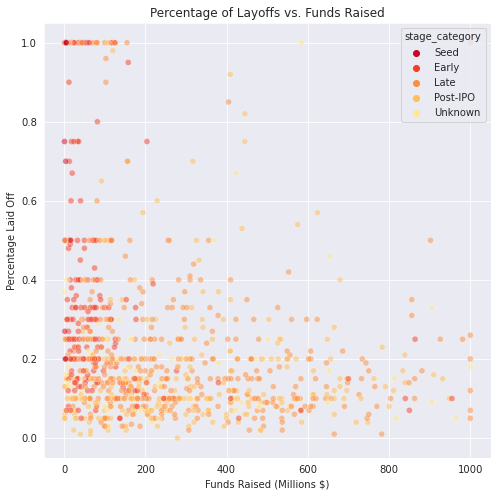

Correlation between 'percentage_laid_off' and 'funds_raised':
All data: Coefficient: -0.07, p-value: 0.02390
Filtered data: Coefficient: -0.28, p-value: 0.00000


In [22]:
# Remove rows with NaNs in 'percentage_laid_off' or 'funds_raised'
df_clean = df.dropna(subset=['percentage_laid_off', 'funds_raised'])

# Remove large outliers using IQR method
Q1 = df['funds_raised'].quantile(0.25)
Q3 = df['funds_raised'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = df_clean[(df_clean['funds_raised'] >= lower_bound) & (df_clean['funds_raised'] <= upper_bound)]

# Scatterplot of 'percentage_laid_off' versus 'funds_raised'
plt.figure(figsize=(8, 8))
sns.scatterplot(data=filtered_df, x='funds_raised', y='percentage_laid_off', 
                hue='stage_category', hue_order=stage_categories, palette='YlOrRd_r', alpha=0.5)
plt.title('Percentage of Layoffs vs. Funds Raised')
plt.xlabel('Funds Raised (Millions $)')
plt.ylabel('Percentage Laid Off')
plt.show()

# Calculate the correlation coefficient and p-value
df_coef, df_p_value = pearsonr(df_clean['percentage_laid_off'], df_clean['funds_raised'])
filtered_df_coef, filtered_df_p_value = pearsonr(filtered_df['percentage_laid_off'], filtered_df['funds_raised'])

print(f"Correlation between 'percentage_laid_off' and 'funds_raised':")
print(f"All data: Coefficient: {df_coef:.2f}, p-value: {df_p_value:.5f}")
print(f"Filtered data: Coefficient: {filtered_df_coef:.2f}, p-value: {filtered_df_p_value:.5f}")


We choose **Spearman's correlation coefficient (spearmanr)** in this case because it is a non-parametric measure of correlation, which means it doesn't assume that the relationship between the variables is linear. Instead, it measures the strength and direction of the monotonic relationship between the two variables.

In the context of the relationship between 'percentage_laid_off' and 'stage_numeric', the relationship might not be strictly linear, and there may be other factors contributing to the relationship. Spearman's correlation coefficient is more robust in such cases as it takes into account the rank order of the data rather than the actual values. This makes it less sensitive to outliers and non-linear relationships.

Using Pearson's correlation coefficient (pearsonr) would be more appropriate if we had a strong assumption that the relationship between the variables is linear. However, in this case, we don't have such an assumption, so Spearman's correlation coefficient is a better choice.

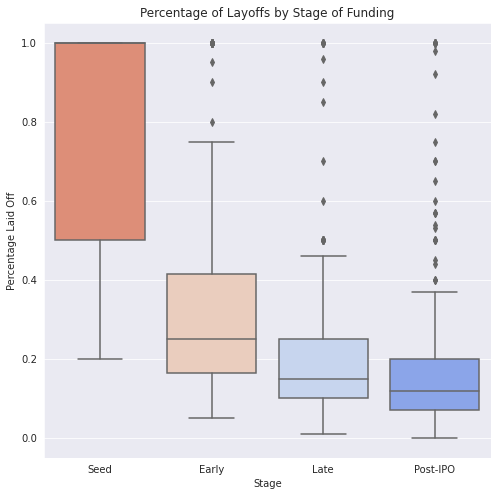

Correlation between 'percentage_laid_off' and 'funds_raised':
Coefficient: -0.37, P-value: 1.57e-32


In [23]:
# Convert 4 categories to numeric values ranked by fund progress
stage_order = {category: i for i, category in enumerate(stage_categories)}
df_clean = df.copy()
df_clean['stage_numeric'] = df_clean['stage_category'].replace(stage_order)

# Remove rows with 'Unknown' stage information
df_clean = df_clean[df_clean['stage_numeric'] != stage_order['Unknown']]

# Remove rows with missing percentage_laid_off and stage_numeric information
df_clean = df_clean.dropna(subset=['percentage_laid_off', 'stage_numeric'])

# Boxplot of 'percentage_laid_off' for each stage of funding
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_clean, x='stage_category', y='percentage_laid_off', order=stage_categories[:-1], palette='coolwarm_r')
plt.title('Percentage of Layoffs by Stage of Funding')
plt.xlabel('Stage')
plt.ylabel('Percentage Laid Off')
plt.show()

# Calculate the correlation coefficient and the significance (p-value)
correlation_coefficient, p_value = spearmanr(df_clean['stage_numeric'], df_clean['percentage_laid_off'])
print(f"Correlation between 'percentage_laid_off' and 'funds_raised':")
print(f"Coefficient: {correlation_coefficient:.2f}, P-value: {p_value:.2e}")

### * 2.3 In which geographic regions are companies with high layoff ratios predominantly located?

[The Biggest Tech Talent Hubs in the U.S. and Canada](https://www.visualcapitalist.com/biggest-tech-talent-hubs-in-us-and-canada/)


In [24]:
df.location.value_counts()[:20]

SF Bay Area        647
New York City      264
Boston             116
Los Angeles         97
Seattle             87
Austin              40
Chicago             37
Salt Lake City      25
Washington D.C.     23
Atlanta             21
Portland            19
Denver              16
Miami               14
Phoenix             13
Boulder             12
Columbus            12
San Diego           11
Philadelphia         9
Detroit              8
Minneapolis          8
Name: location, dtype: int64

In [25]:
top_layoff_companies.location.value_counts()[:20]

SF Bay Area        106
New York City       48
Boston              22
Los Angeles         22
Seattle             14
Austin               6
Chicago              4
Portland             4
Minneapolis          3
Columbus             3
Washington D.C.      3
Nashville            3
Las Vegas            2
Pittsburgh           2
Salt Lake City       2
Miami                2
Phoenix              1
Spokane              1
Denver               1
Sao Paulo            1
Name: location, dtype: int64

## 3. Has the wave of layoffs reached its peak, or is it still ongoing, and what are the potential future trends of the layoff wave?

In [26]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Aggregate layoff data by date
df_daily = df.groupby('date').sum()['total_laid_off'].reset_index()

# check the date range
min(df.date), max(df.date)

(Timestamp('2020-03-11 00:00:00'), Timestamp('2023-04-28 00:00:00'))

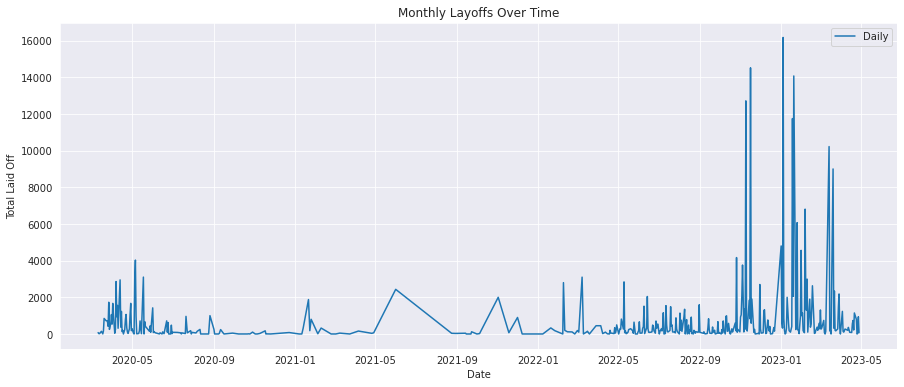

In [27]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_daily, x='date', y='total_laid_off', label='Daily')
plt.title('Monthly Layoffs Over Time')
plt.xlabel('Date')
plt.ylabel('Total Laid Off')
plt.legend()
plt.show()

In [28]:
df_daily[(df_daily['date'].dt.year == 2021)].shape # few data in 2021

(29, 2)

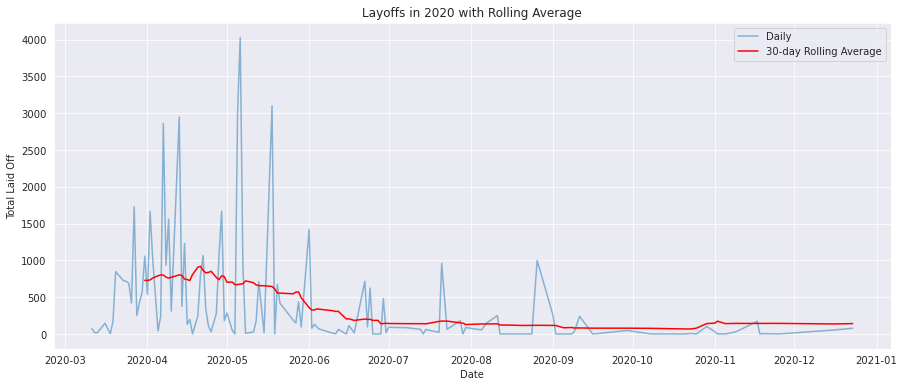

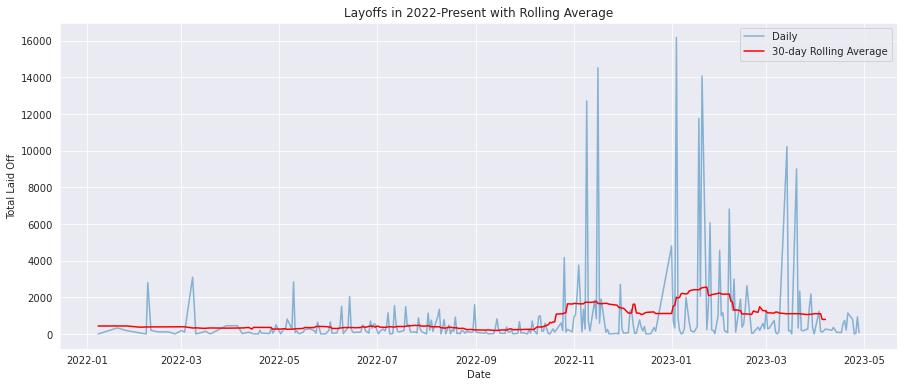

In [29]:
# Calculate the 30-day rolling average
df_daily['rolling_avg'] = df_daily['total_laid_off'].rolling(window=30, center=True).mean()

# Filter data by year
df_2020 = df_daily[(df_daily['date'].dt.year == 2020)]
df_2022_present = df_daily[(df_daily['date'].dt.year >= 2022)]

# Create a function to plot the data
def plot_layoffs_by_year(df, title):
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df, x='date', y='total_laid_off', alpha=0.5, label='Daily')
    sns.lineplot(data=df, x='date', y='rolling_avg', color='red', label='30-day Rolling Average')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Total Laid Off')
    plt.legend()
    plt.show()

# Plot the data for 2020
plot_layoffs_by_year(df_2020, 'Layoffs in 2020 with Rolling Average')

# Plot the data for 2022-present
plot_layoffs_by_year(df_2022_present, 'Layoffs in 2022-Present with Rolling Average')

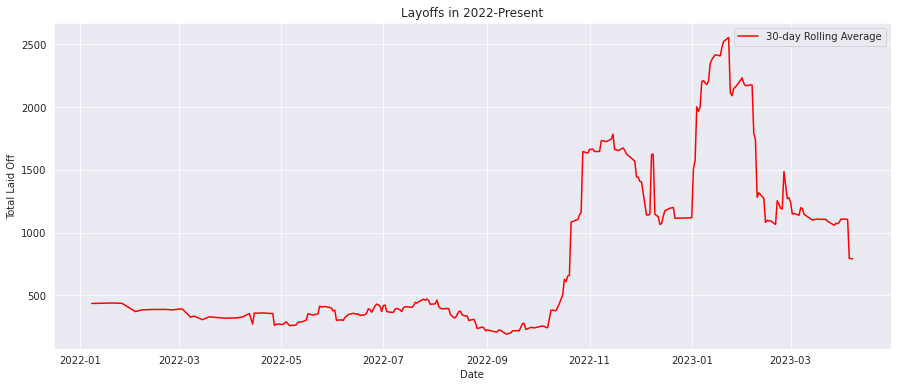

In [30]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_2022_present, x='date', y='rolling_avg', color='red', label='30-day Rolling Average')
plt.title('Layoffs in 2022-Present')
plt.xlabel('Date')
plt.ylabel('Total Laid Off')
plt.legend()
plt.show()

ADF Statistic: 2.3202094012443855
p-value: 0.9989676656065839
ADF Statistic: -3.65
p-value: 0.00
The time series is stationary after 2th-order differencing.


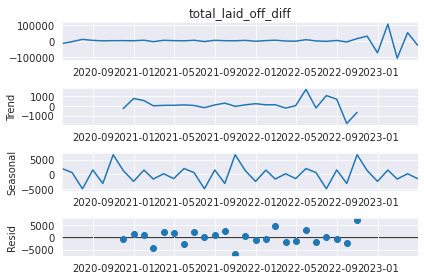

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -267.704
Date:                            Fri, 26 May 2023   AIC                            541.408
Time:                                    18:39:34   BIC                            544.943
Sample:                                05-31-2020   HQIC                           542.346
                                     - 04-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3284      0.113    -11.795      0.000      -1.549      -1.108
ar.L2         -0.5900      0.120   

In [31]:
# Filter the data to include only data from 2022 onwards
monthly_layoffs = df.resample('M', on='date').sum()#.reset_index() [df['date'] >= pd.to_datetime('2021-04-01')]

# Set the frequency of the DatetimeIndex explicitly
monthly_layoffs.index.freq = 'M'

# Perform stability test (e.g., Augmented Dickey-Fuller test)
result = adfuller(monthly_layoffs['total_laid_off'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Apply differencing and perform the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(monthly_layoffs['total_laid_off'].diff().diff().dropna())

print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2f}')

# Interpret the test result
if adf_result[1] < 0.05:
    print("The time series is stationary after 2th-order differencing.")
else:
    print("The time series is not stationary afterdifferencing.")

monthly_layoffs['total_laid_off_diff'] = monthly_layoffs['total_laid_off'].diff().diff()

# Perform seasonality test (e.g., seasonal decomposition)
seasonal_decomposition = seasonal_decompose(monthly_layoffs['total_laid_off_diff'].dropna(), model='additive')
seasonal_decomposition.plot()
plt.show()

# Determine the appropriate parameters for ARIMA or SARIMA
# Here, we use auto_arima from the pmdarima package to determine the best parameters
best_model = auto_arima(monthly_layoffs['total_laid_off_diff'].dropna(), seasonal=True, m=12, suppress_warnings=True, stepwise=True)
print(best_model.summary())

In [32]:
monthly_layoffs[:5]

,total_laid_off,percentage_laid_off,funds_raised,total_laid_off_diff
date,,,,
2020-03-31,7850.0,25.41,15530.2,NaN
2020-04-30,19821.0,34.73,43862.0,NaN
2020-05-31,14674.0,14.43,74191.0,-17118.0
2020-06-30,3926.0,7.41,11724.1,-5601.0
2020-07-31,1612.0,1.91,4447.0,8434.0


In [33]:
print(monthly_layoffs['total_laid_off'].std())

14082.7652143499


p < 0.05, you can reject the null hypothesis, and it suggests that the time series is stationary.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43829D+00    |proj g|=  2.52317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   8.633D-06   7.436D+00
  F =   7.4362286823193466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
count       36.000000
mean      -957.511674
std      14848.935826
min     -35967.585750
25%      -6952.517651
50%        207.190595
75%       3489.259588
max      40196.637952
dtype: float64


 This problem is unconstrained.


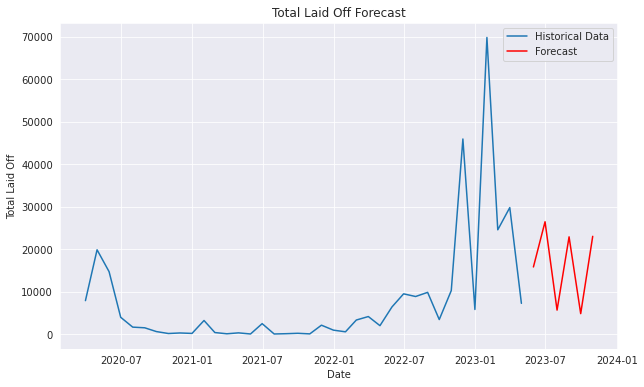

In [34]:
# Fit the model to the data
model = sm.tsa.statespace.SARIMAX(monthly_layoffs['total_laid_off_diff'].dropna(), order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))
results = model.fit()

# Validate the model: Check the residuals
residuals = results.resid
print(residuals.describe())

# Make forecasts
forecast = results.get_forecast(steps=6)
forecast_conf_int = forecast.conf_int()

# Get the last observed value
last_observed_value = monthly_layoffs['total_laid_off'].iloc[-1]

# Convert the forecasted values and confidence intervals to the original scale
forecast_original_scale = last_observed_value + forecast.predicted_mean.cumsum()
forecast_conf_int['lower'] = last_observed_value + forecast_conf_int.iloc[:, 0].cumsum()
forecast_conf_int['upper'] = last_observed_value + forecast_conf_int.iloc[:, 1].cumsum()

# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame({
    'total_laid_off': forecast_original_scale,
    'lower_bound': forecast_conf_int['lower'],
    'upper_bound': forecast_conf_int['upper']
})

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_layoffs.index, monthly_layoffs['total_laid_off'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['total_laid_off'], color='red', label='Forecast')
# plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], color='pink', alpha=0.3)
plt.title('Total Laid Off Forecast')
plt.xlabel('Date')
plt.ylabel('Total Laid Off')
plt.legend()
plt.show()

Total layoff: Using the total number of layoffs can be useful when assessing the overall impact of the layoff wave on the labor market or the economy. It gives a more accurate picture of the total number of employees affected by layoffs. However, comparing total layoffs across companies or industries may be misleading if there are significant differences in company size or workforce.
